## **INFO 4300 - Predictive Analytics**
### **Class Project - World Bank Data Set, Modeling**
Jacob Shumway  

In [1]:
# Import libraries needed for analysis
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import logit, probit, poisson, ols
import shap
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns
%matplotlib inline

In [2]:
# Fix random seed for consistency
np.random.seed(1111)

In [3]:
# Import data for analysis
analysis_data = pd.read_csv('https://raw.githubusercontent.com/jshumway0475/Predictive-Analytics/main/wb_clean_data_countries.csv')
analysis_data.drop(columns = 'Unnamed: 0', inplace = True)
analysis_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2751 entries, 0 to 2750
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   economy            2751 non-null   object 
 1   time               2751 non-null   object 
 2   EG.ELC.ACCS.ZS     2751 non-null   float64
 3   EG.ELC.COAL.ZS     2751 non-null   float64
 4   EG.ELC.FOSL.ZS     2751 non-null   float64
 5   EG.ELC.HYRO.ZS     2751 non-null   float64
 6   EG.ELC.LOSS.ZS     2751 non-null   float64
 7   EG.ELC.NGAS.ZS     2751 non-null   float64
 8   EG.ELC.NUCL.ZS     2751 non-null   float64
 9   EG.ELC.PETR.ZS     2751 non-null   float64
 10  EG.ELC.RNWX.ZS     2751 non-null   float64
 11  EN.ATM.GHGT.KT.CE  2751 non-null   float64
 12  EN.ATM.METH.KT.CE  2751 non-null   float64
 13  NE.EXP.GNFS.ZS     2751 non-null   float64
 14  NE.IMP.GNFS.ZS     2751 non-null   float64
 15  NV.AGR.TOTL.ZS     2751 non-null   float64
 16  NV.IND.MANF.ZS     2751 

## **Question 1 - What factors drive quality of life?**
### Target variable: gdp_per_capita (used as a high level proxy as a measure of quality of life)

In [4]:
analysis_data.columns

Index(['economy', 'time', 'EG.ELC.ACCS.ZS', 'EG.ELC.COAL.ZS', 'EG.ELC.FOSL.ZS',
       'EG.ELC.HYRO.ZS', 'EG.ELC.LOSS.ZS', 'EG.ELC.NGAS.ZS', 'EG.ELC.NUCL.ZS',
       'EG.ELC.PETR.ZS', 'EG.ELC.RNWX.ZS', 'EN.ATM.GHGT.KT.CE',
       'EN.ATM.METH.KT.CE', 'NE.EXP.GNFS.ZS', 'NE.IMP.GNFS.ZS',
       'NV.AGR.TOTL.ZS', 'NV.IND.MANF.ZS', 'NV.IND.TOTL.ZS', 'NV.SRV.TOTL.ZS',
       'NY.GDP.MKTP.CD', 'SP.DYN.LE00.FE.IN', 'SP.DYN.TFRT.IN', 'SP.POP.TOTL',
       'SP.URB.TOTL', 'year', 'gdp_per_capita', 'ghge_per_capita',
       'c2e_per_capita', 'urb_pop_pct'],
      dtype='object')

In [5]:
# Split the data set into predictors and target
X1 = analysis_data[['EG.ELC.ACCS.ZS', 'EG.ELC.COAL.ZS', 'EG.ELC.HYRO.ZS', 'EG.ELC.LOSS.ZS', 'EG.ELC.NGAS.ZS', 
                    'EG.ELC.NUCL.ZS', 'EG.ELC.PETR.ZS', 'EG.ELC.RNWX.ZS', 'NE.EXP.GNFS.ZS', 'NE.IMP.GNFS.ZS', 
                    'NV.AGR.TOTL.ZS', 'NV.IND.TOTL.ZS', 'NV.SRV.TOTL.ZS', 'SP.DYN.LE00.FE.IN', 'SP.DYN.TFRT.IN', 
                    'ghge_per_capita', 'urb_pop_pct']]
y1 = analysis_data['gdp_per_capita']

## **Unsupervised Methods - PCA and k-means**
> Move forward with PCA to view the potential factors and the loading for each variable within the factors

In [6]:
# Normalize the predictors
norm_X = StandardScaler().fit_transform(X1)

Text(0, 0.5, 'Cumulative explained variance')

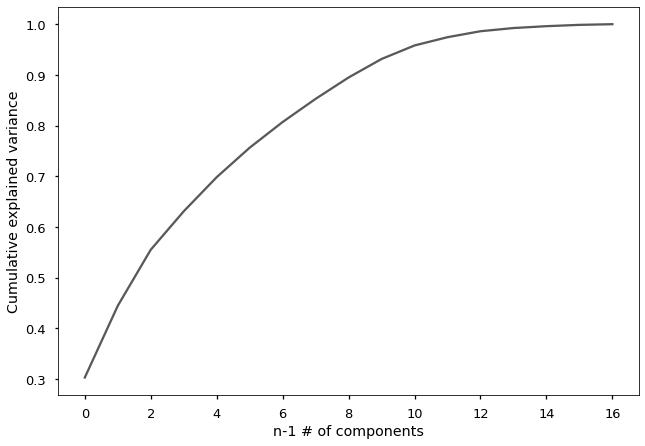

In [7]:
# Set the style
plt.style.use('seaborn-talk')
# Determine the appropriate number of components for analysis
pca = PCA().fit(norm_X)
plt.plot(np.cumsum(pca.explained_variance_ratio_), color = '#595959')
plt.xlabel('n-1 # of components')
plt.ylabel('Cumulative explained variance')

In [8]:
n_components = 6
pca = PCA(n_components).fit(norm_X)
print(f'{round(np.sum(pca.explained_variance_ratio_)*100, 2)}% of variance is described by {n_components} components')

75.63% of variance is described by 6 components


In [9]:
# Review component loadings
pca_loadings = pd.DataFrame(pca.components_.T, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], index = X1.columns)
pca_loadings.style.applymap(lambda x: 'background-color: #595959' if (abs(x) >= 0.25) else '')

,PC1,PC2,PC3,PC4,PC5,PC6
EG.ELC.ACCS.ZS,-0.358509,0.023526,-0.092499,-0.130759,-0.176933,-0.043863
EG.ELC.COAL.ZS,-0.082952,-0.110751,-0.210929,0.711069,0.166622,0.160493
EG.ELC.HYRO.ZS,0.189721,-0.179774,-0.113694,-0.606026,0.259375,-0.055726
EG.ELC.LOSS.ZS,0.275125,-0.020363,0.103546,-0.066080,-0.055392,-0.051698
EG.ELC.NGAS.ZS,-0.088053,0.441073,-0.028588,-0.086830,0.131903,0.269162
EG.ELC.NUCL.ZS,-0.166671,-0.161599,-0.150397,0.085632,0.206640,-0.570113
EG.ELC.PETR.ZS,0.070894,0.005494,0.412703,0.126620,-0.698385,-0.195021
EG.ELC.RNWX.ZS,-0.089288,-0.228786,0.121251,-0.114570,-0.120399,0.698577
NE.EXP.GNFS.ZS,-0.195706,0.266799,0.491553,0.002519,0.313671,-0.033401
NE.IMP.GNFS.ZS,-0.139858,0.092515,0.612277,0.039917,0.318214,-0.070839


In [10]:
# Split dataframe into test and train
X = pd.DataFrame(pca.fit_transform(norm_X), columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
X = pd.merge(X, pd.get_dummies(analysis_data['economy']), how = 'left', left_index = True, right_index = True)

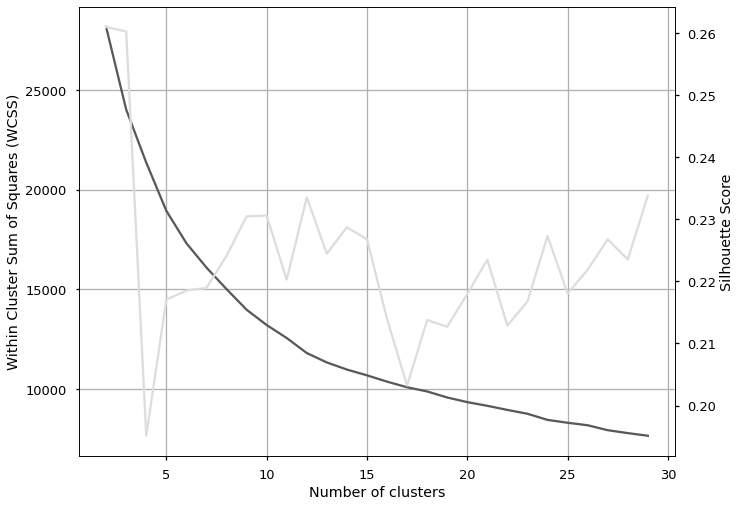

In [11]:
# Identify number of clusters to use in K-means using wcss-elbow method
# Select dataframe and columns to test
array = X

# Elbow test
N = 30 # maximum number of clusters to test
wcss = []
silhouette = []

for n in range(2, N):
    kmeans = KMeans(n).fit(array)
    cluster_id = kmeans.fit_predict(array)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)
    score = metrics.silhouette_score(array, cluster_id, metric = 'euclidean')
    silhouette.append(score)

# Plot results
cluster_ct = range(2, N)
fig, ax1 = plt.subplots()
ax1.plot(cluster_ct, wcss, color = '#595959')
ax1.set_ylabel('Within Cluster Sum of Squares (WCSS)')
ax1.grid(True)
ax2 = ax1.twinx()
ax2.plot(cluster_ct, silhouette, color = '#DDDDDD')
ax2.set_ylabel('Silhouette Score')
ax2.grid(False)
ax1.set_xlabel('Number of clusters')
fig.tight_layout()

In [12]:
# Perform K-means calculations on selected array
clusters = KMeans(10).fit(array)
cluster_id = clusters.fit_predict(array)

# Add cluster id to dataframe
array['Cluster_ID'] = cluster_id

In [13]:
array.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'AGO', 'ALB', 'ARE', 'ARG',
       ...
       'UKR', 'URY', 'USA', 'UZB', 'VEN', 'VNM', 'ZAF', 'ZMB', 'ZWE',
       'Cluster_ID'],
      dtype='object', length=131)

In [14]:
#country_clusterID = pd.merge(analysis_data[['economy', 'year']], array['Cluster_ID'], how = 'inner', left_index = True, right_index = True)
#country_clusterID.to_csv('country_clusterID.csv')

## **Supervised Methods - Linear Regression, Random Forest**

In [15]:
X = array[['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'Cluster_ID']]
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size = 0.25)
train_data = pd.merge(X_train, y_train, how = 'inner', left_index = True, right_index = True)

In [16]:
# Build linear regression model, transforming the target variable in order to meet normality requirement
qual_life_model = ols('np.log(gdp_per_capita) ~ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + C(Cluster_ID)', train_data).fit()
anova_table = sm.stats.anova_lm(qual_life_model, typ = 1)
print(anova_table)

                   df       sum_sq     mean_sq            F         PR(>F)
C(Cluster_ID)     9.0  2909.144515  323.238279   741.004484   0.000000e+00
PC1               1.0   674.394432  674.394432  1546.009028  2.221797e-252
PC2               1.0     2.496219    2.496219     5.722433   1.683922e-02
PC3               1.0    23.350074   23.350074    53.528653   3.640998e-13
PC4               1.0    26.636420   26.636420    61.062405   8.768681e-15
PC5               1.0     9.195186    9.195186    21.079415   4.673844e-06
PC6               1.0     3.902516    3.902516     8.946285   2.813530e-03
Residual       2047.0   892.934891    0.436216          NaN            NaN


In [17]:
print(qual_life_model.summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(gdp_per_capita)   R-squared:                       0.803
Model:                                OLS   Adj. R-squared:                  0.802
Method:                     Least Squares   F-statistic:                     557.7
Date:                    Thu, 18 Nov 2021   Prob (F-statistic):               0.00
Time:                            10:25:17   Log-Likelihood:                -2063.5
No. Observations:                    2063   AIC:                             4159.
Df Residuals:                        2047   BIC:                             4249.
Df Model:                              15                                         
Covariance Type:                nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

Text(0.5, 1.0, 'Actual vs Predicted')

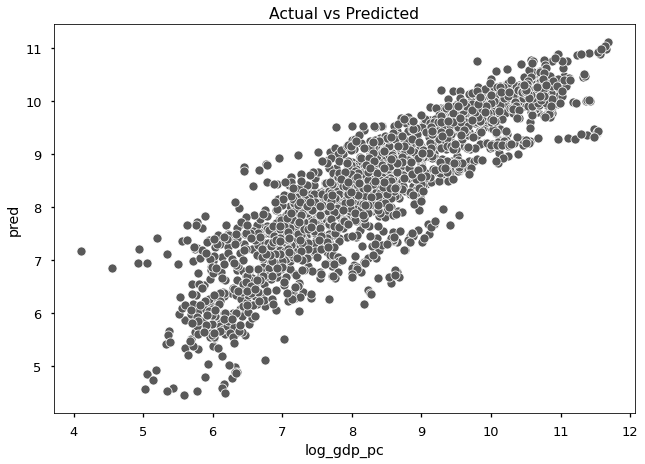

In [18]:
# Show scatterplot of actual vs predicted and residuals
train_data['pred'] = qual_life_model.fittedvalues
train_data['resid'] = qual_life_model.resid
train_data['log_gdp_pc'] = np.log(train_data['gdp_per_capita'])
plt = sns.scatterplot(x = 'log_gdp_pc', y = 'pred', data = train_data, color = '#595959')
plt.set_title('Actual vs Predicted')

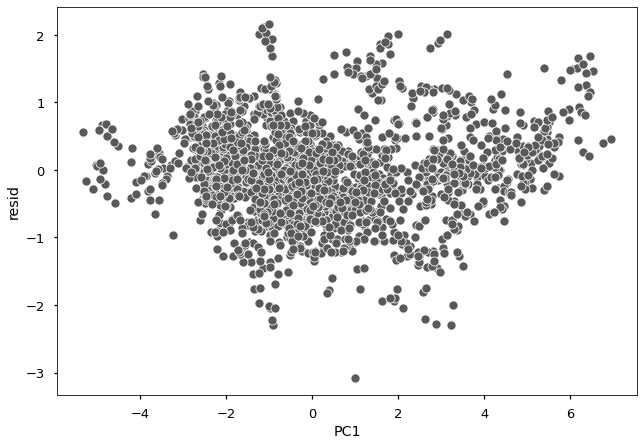

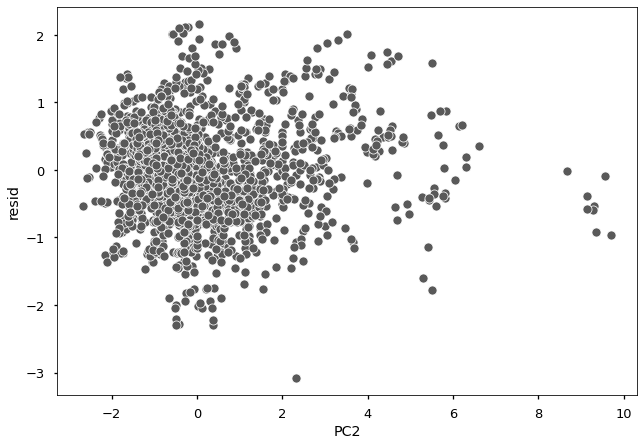

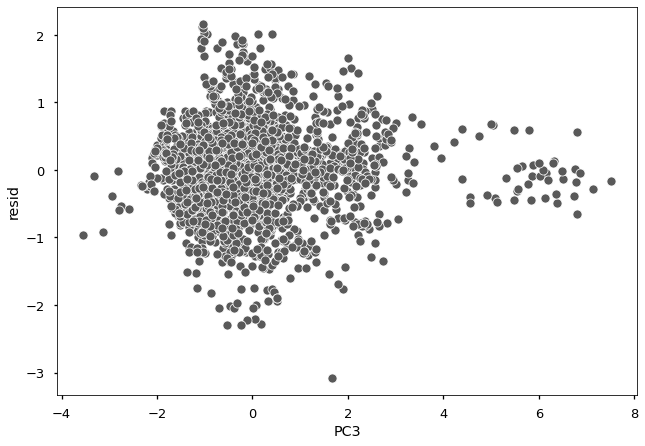

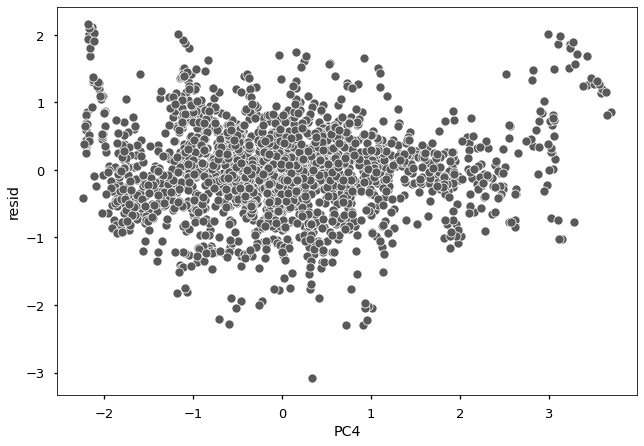

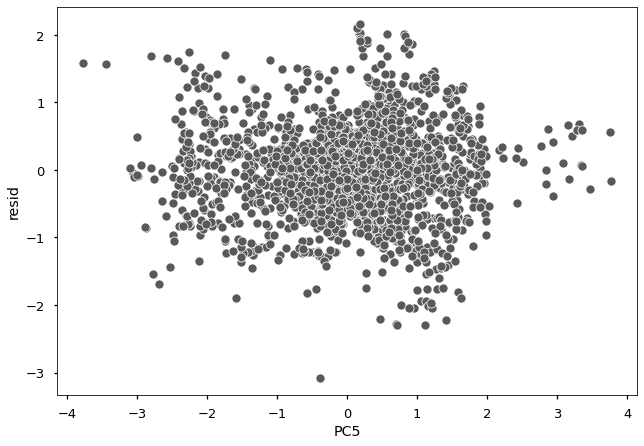

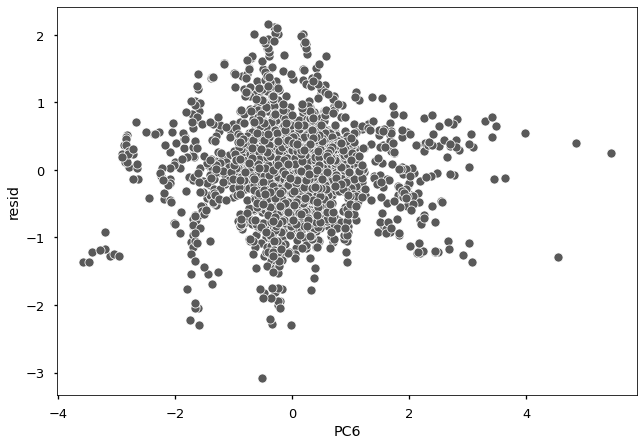

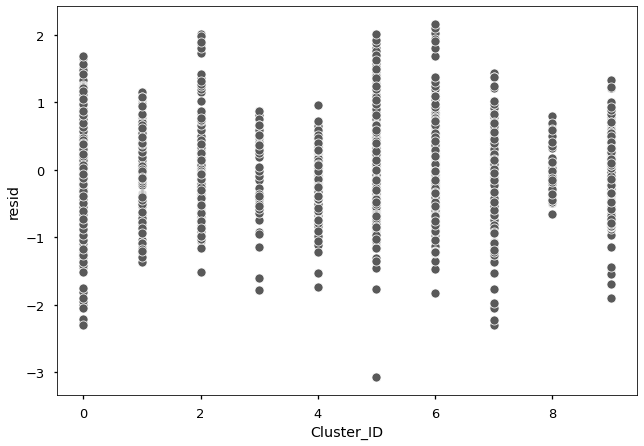

In [19]:
# Show residual plots for each variable
import matplotlib.pyplot as plt
C = list(train_data.keys())
c_exclude = ['gdp_per_capita', 'pred', 'resid', 'log_gdp_pc']
for i in c_exclude:
    C.remove(i)
ct = 0
for c in C:
    plt.figure(ct)
    sns.scatterplot(data = train_data, x = c, y = 'resid', color = '#595959')
    ct = ct + 1

Text(0.5, 1.0, 'Probability Plot')

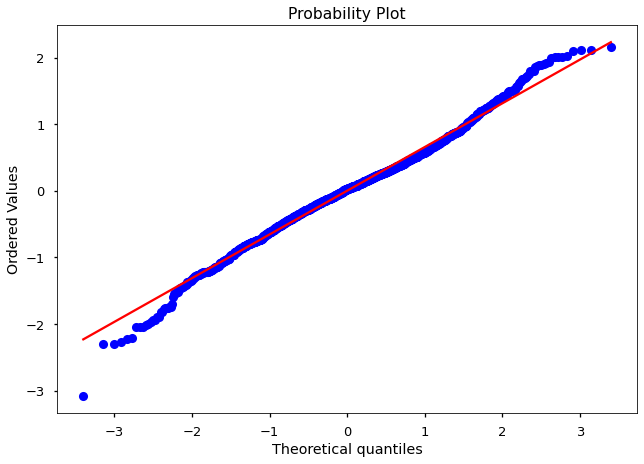

In [20]:
# Normal plot for residuals
stats.probplot(train_data['resid'], dist = "norm", plot = plt)
plt.title("Probability Plot")

Transformed
R2 of predictions on test data set = 0.7917


<AxesSubplot:xlabel='log_gdp_pc', ylabel='Predicted'>

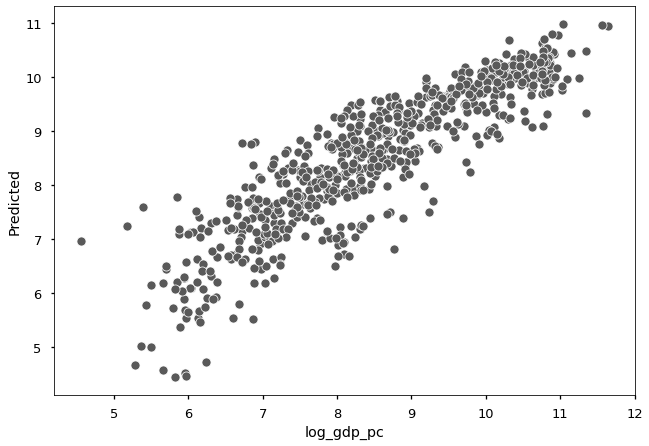

In [21]:
# Evaluate model results on untransformed target
y_pred = qual_life_model.predict(X_test)
y_test = pd.DataFrame(y_test)
y_test['Predicted'] = y_pred
y_test['Predicted_raw'] = np.exp(y_pred)
y_test.dropna(inplace = True)
y_test['gdp_per_capita'] = pd.to_numeric(y_test.gdp_per_capita)
y_test['log_gdp_pc'] = np.log(y_test['gdp_per_capita'])
print('Transformed')
print(f'R2 of predictions on test data set = {round(y_test["log_gdp_pc"].corr(y_test["Predicted"])**2, 4)}')
sns.scatterplot(x = 'log_gdp_pc', y = 'Predicted', data = y_test, color = '#595959')

Untransformed
R2 of predictions on test data set = 0.717


<AxesSubplot:xlabel='gdp_per_capita', ylabel='Predicted_raw'>

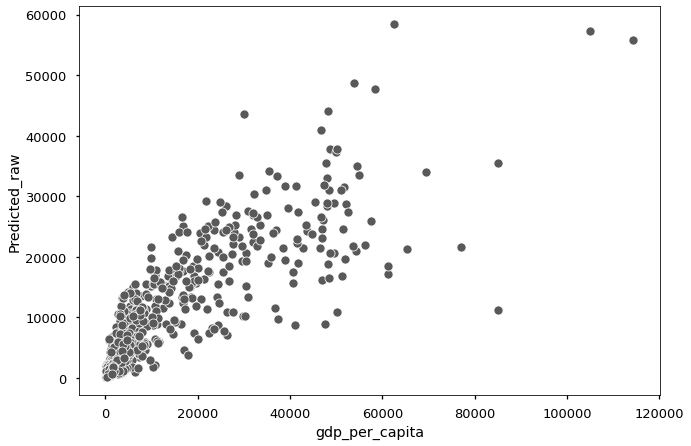

In [22]:
print('Untransformed')
print(f'R2 of predictions on test data set = {round(y_test["gdp_per_capita"].corr(y_test["Predicted_raw"])**2, 4)}')
sns.scatterplot(x = 'gdp_per_capita', y = 'Predicted_raw', data = y_test, color = '#595959')

## **Random Forest model to predict quality of life (gdp_per_capita)**

In [23]:
# Prepare data set for random forest regression
X_rf = pd.merge(X1, array['Cluster_ID'], how = 'inner', left_index = True, right_index = True)
X_rf = pd.merge(X_rf, pd.get_dummies(X_rf['Cluster_ID']), how = 'inner', left_index = True, right_index = True)
X_rf.drop(columns = ['Cluster_ID'], inplace = True)

In [24]:
# Create testing and training data sets
X_train, X_test, y_train, y_test = train_test_split(X_rf, y1, test_size = 0.25)

In [25]:
# Initiate model with 1000 decision trees
qual_life_model_rf = RandomForestRegressor(n_estimators = 1000)
qual_life_model_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000)

In [26]:
# Evaluate model accuracy using test dataset
y_pred_test = qual_life_model_rf.predict(X_test)
y_pred_train = qual_life_model_rf.predict(X_train)

In [27]:
# Calculate regression tree error metrics
mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
mse_train = metrics.mean_squared_error(y_train, y_pred_train, squared = True)
rmse_train = metrics.mean_squared_error(y_train, y_pred_train, squared = False)
mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
mse_test = metrics.mean_squared_error(y_test, y_pred_test, squared = True)
rmse_test = metrics.mean_squared_error(y_test, y_pred_test, squared = False)
print(f'mean absolute error of the train data set = {round(mae_train, 4)}')
print(f'mean absolute error of the test data set = {round(mae_test, 4)}')
print()
print(f'mean squared error of the train data set = {round(mse_train, 4)}')
print(f'mean squared error of the test data set = {round(mse_test, 4)}')
print()
print(f'root mean squared error of the train data set = {round(rmse_train, 4)}')
print(f'root mean squared error of the test data set = {round(rmse_test, 4)}')

mean absolute error of the train data set = 508.6218
mean absolute error of the test data set = 1576.9

mean squared error of the train data set = 948089.5406
mean squared error of the test data set = 10050721.6242

root mean squared error of the train data set = 973.6989
root mean squared error of the test data set = 3170.2873


R2 of predictions on test data set = 0.9688


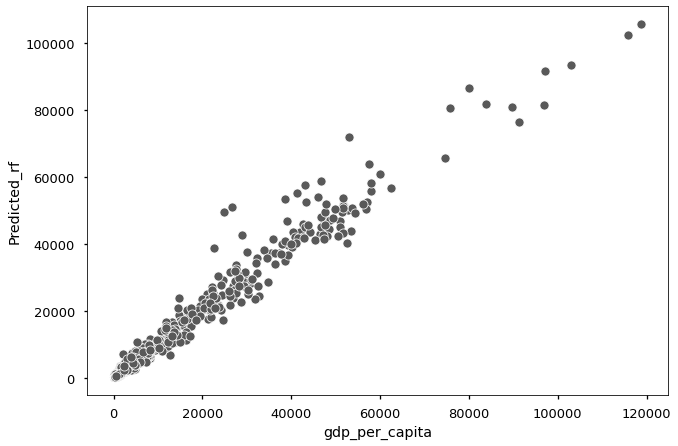

In [28]:
# Evaluate model
y_test = pd.DataFrame(y_test)
y_test['Predicted_rf'] = y_pred_test
y_test.dropna(inplace = True)
y_test['gdp_per_capita'] = pd.to_numeric(y_test.gdp_per_capita)
#y_test['log_gdp_pc'] = np.log(y_test['gdp_per_capita'])
sns.scatterplot(x = 'gdp_per_capita', y = 'Predicted_rf', data = y_test, color = '#595959')
print(f'R2 of predictions on test data set = {round(y_test["gdp_per_capita"].corr(y_test["Predicted_rf"])**2, 4)}')

In [29]:
# Determine variable importance for random forest model
importances = list(qual_life_model_rf.feature_importances_)

# Create tuples with variable name and importance then sort by importance descending
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_rf.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Create dataframe of feature importance and filter to variables with importance > 0
feature_importances_df = pd.DataFrame(feature_importances)
feature_importances_df.rename(columns = {0:'feature', 1:'importance'}, inplace = True)
feature_importances_df[feature_importances_df['importance'] > 0]

,feature,importance
0,NV.AGR.TOTL.ZS,0.41
1,SP.DYN.LE00.FE.IN,0.33
2,EG.ELC.PETR.ZS,0.08
3,EG.ELC.RNWX.ZS,0.05
4,ghge_per_capita,0.03
5,urb_pop_pct,0.03
6,EG.ELC.LOSS.ZS,0.01
7,EG.ELC.NGAS.ZS,0.01
8,NV.IND.TOTL.ZS,0.01
9,NV.SRV.TOTL.ZS,0.01


In [30]:
# Retrain model with constrained feature list based on initial model feature importance
feature_list = list(feature_importances_df[feature_importances_df['importance'] > 0.01]['feature'])
X_rf2 = X_rf[feature_list]

# Create testing and training data sets
X_train, X_test, y_train, y_test = train_test_split(X_rf2, y1, test_size = 0.25)

## **Random Forest Parameter Tuning**
### [Article on Medium that provides a good walkthrough](https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d)
### [Another good article for perspective on overfitting](https://towardsdatascience.com/one-common-misconception-about-random-forest-and-overfitting-47cae2e2c23b)

Text(0.5, 0, 'n_estimators')

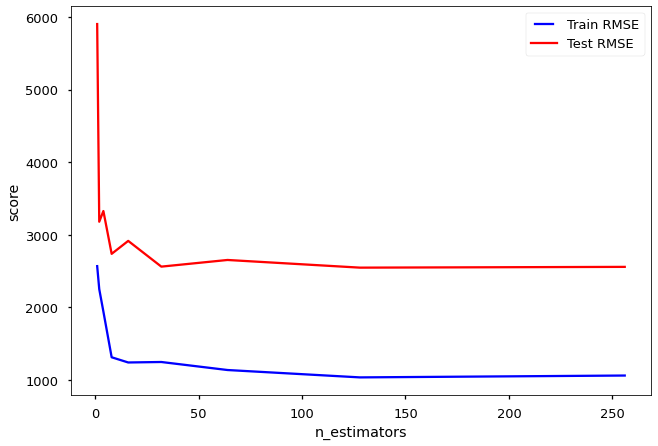

In [31]:
# Determine appropriate number of decision trees
n_estimators = [1, 2, 4, 8, 16, 32, 64, 128, 256]
train_rmse_results = []
test_rmse_results = []
for estimator in n_estimators:
    rf_sens = RandomForestRegressor(n_estimators = estimator)
    rf_sens.fit(X_train, y_train)
    train_pred_sens = rf_sens.predict(X_train)
    rmse_train = metrics.mean_squared_error(y_train, train_pred_sens, squared = False)
    train_rmse_results.append(rmse_train)
    test_pred_sens = rf_sens.predict(X_test)
    rmse_test = metrics.mean_squared_error(y_test, test_pred_sens, squared = False)
    test_rmse_results.append(rmse_test)
line1, = plt.plot(n_estimators, train_rmse_results, 'b', label = 'Train RMSE')
line2, = plt.plot(n_estimators, test_rmse_results, 'r', label = 'Test RMSE')
plt.legend(handler_map = {line1: HandlerLine2D(numpoints = 2)})
plt.ylabel('score')
plt.xlabel('n_estimators')

Text(0.5, 0, 'Tree Depth')

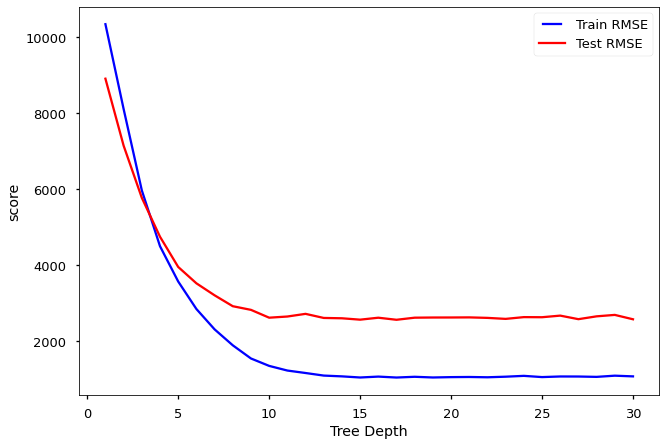

In [32]:
# Determine the approprate tree depth to avoid overfitting
max_depths = np.linspace(1, 30, 30, endpoint = True)
train_rmse_results = []
test_rmse_results = []
for max_depth in max_depths:
    rf_sens = RandomForestRegressor(n_estimators = 150, max_depth = max_depth)
    rf_sens.fit(X_train, y_train)
    train_pred_sens = rf_sens.predict(X_train)
    rmse_train = metrics.mean_squared_error(y_train, train_pred_sens, squared = False)
    train_rmse_results.append(rmse_train)
    test_pred_sens = rf_sens.predict(X_test)
    rmse_test = metrics.mean_squared_error(y_test, test_pred_sens, squared = False)
    test_rmse_results.append(rmse_test)
line1, = plt.plot(max_depths, train_rmse_results, 'b', label = 'Train RMSE')
line2, = plt.plot(max_depths, test_rmse_results, 'r', label = 'Test RMSE')
plt.legend(handler_map = {line1: HandlerLine2D(numpoints = 2)})
plt.ylabel('score')
plt.xlabel('Tree Depth')

In [33]:
# Initiate model with 150 decision trees but leaving max_depth at default
qual_life_model_rf2 = RandomForestRegressor(n_estimators = 150)
qual_life_model_rf2.fit(X_train, y_train)

RandomForestRegressor(n_estimators=150)

In [34]:
# Evaluate model accuracy using test dataset
y_pred_test = qual_life_model_rf2.predict(X_test)
y_pred_train = qual_life_model_rf2.predict(X_train)

In [35]:
# Calculate regression tree error metrics
mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
mse_train = metrics.mean_squared_error(y_train, y_pred_train, squared = True)
rmse_train = metrics.mean_squared_error(y_train, y_pred_train, squared = False)
mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
mse_test = metrics.mean_squared_error(y_test, y_pred_test, squared = True)
rmse_test = metrics.mean_squared_error(y_test, y_pred_test, squared = False)
print(f'mean absolute error of the train data set = {round(mae_train, 4)}')
print(f'mean absolute error of the test data set = {round(mae_test, 4)}')
print()
print(f'mean squared error of the train data set = {round(mse_train, 4)}')
print(f'mean squared error of the test data set = {round(mse_test, 4)}')
print()
print(f'root mean squared error of the train data set = {round(rmse_train, 4)}')
print(f'root mean squared error of the test data set = {round(rmse_test, 4)}')

mean absolute error of the train data set = 564.7796
mean absolute error of the test data set = 1284.0562

mean squared error of the train data set = 1103017.5968
mean squared error of the test data set = 6730954.1201

root mean squared error of the train data set = 1050.2464
root mean squared error of the test data set = 2594.4082


R2 of predictions on test data set = 0.972


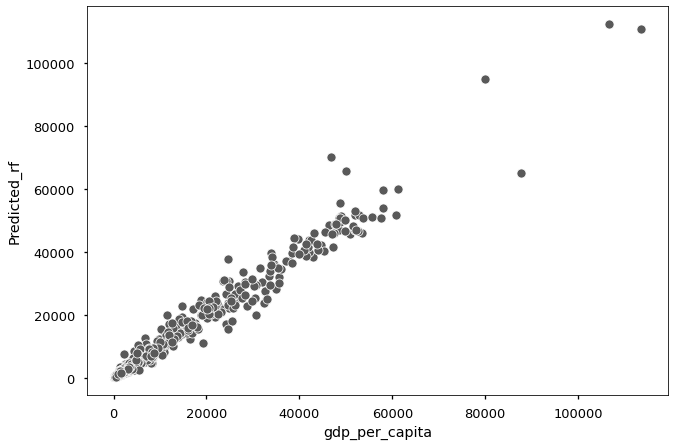

In [36]:
# Evaluate model
y_test = pd.DataFrame(y_test)
y_test['Predicted_rf'] = y_pred_test
y_test.dropna(inplace = True)
y_test['gdp_per_capita'] = pd.to_numeric(y_test.gdp_per_capita)
#y_test['log_gdp_pc'] = np.log(y_test['gdp_per_capita'])
sns.scatterplot(x = 'gdp_per_capita', y = 'Predicted_rf', data = y_test, color = '#595959')
print(f'R2 of predictions on test data set = {round(y_test["gdp_per_capita"].corr(y_test["Predicted_rf"])**2, 4)}')

In [37]:
# Determine variable importance for random forest model
importances2 = list(qual_life_model_rf2.feature_importances_)

# Create tuples with variable name and importance then sort by importance descending
feature_importances2 = [(feature, round(importance, 2)) for feature, importance in zip(X_rf2.columns, importances2)]
feature_importances2 = sorted(feature_importances2, key = lambda x: x[1], reverse = True)

# Create dataframe of feature importance and filter to variables with importance > 0
feature_importances_df2 = pd.DataFrame(feature_importances2)
feature_importances_df2.rename(columns = {0:'feature', 1:'importance'}, inplace = True)
feature_importances_df2[feature_importances_df2['importance'] > 0]

,feature,importance
0,SP.DYN.LE00.FE.IN,0.48
1,NV.AGR.TOTL.ZS,0.29
2,EG.ELC.PETR.ZS,0.10
3,EG.ELC.RNWX.ZS,0.04
4,ghge_per_capita,0.04
5,urb_pop_pct,0.04


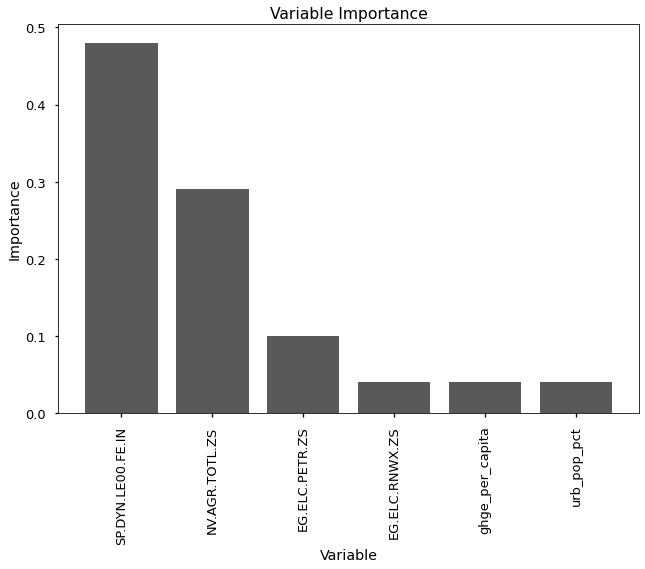

In [38]:
# list of x locations for plotting
x_values = list(range(len(feature_importances_df2['importance'])))
# Make a bar chart
plt.bar(x_values, feature_importances_df2['importance'], orientation = 'vertical', color = '#595959')
# Tick labels for x axis
plt.xticks(x_values, list(feature_importances_df2['feature']), rotation = 'vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importance');

In [39]:
# Explain RF model predictions using SHAP, running model takes about 2 - 5 mins for test data set
run_model = 1
if run_model == 1:
    shap.initjs()
    explainer = shap.TreeExplainer(qual_life_model_rf2)
    expected_value = explainer.expected_value
    shap_values = explainer.shap_values(X_test)

In [40]:
X_test.iloc[27]

NV.AGR.TOTL.ZS        3.182262
SP.DYN.LE00.FE.IN    80.400000
EG.ELC.PETR.ZS        2.169469
EG.ELC.RNWX.ZS        0.491261
ghge_per_capita       0.029145
urb_pop_pct          85.403003
Name: 95, dtype: float64

In [41]:
X_test['SP.DYN.LE00.FE.IN'].mean()

72.8291904069767

The expected value is  12377.29090742865
The predicted value is  24759.19938651844


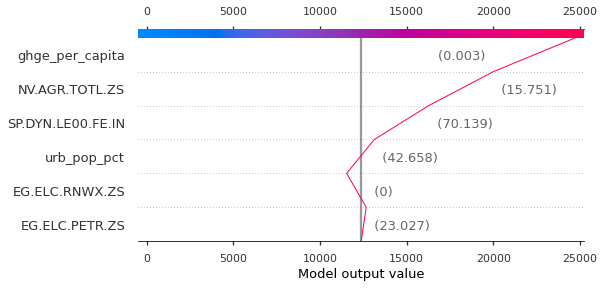

In [42]:
# The expected value is roughly the average of the all of the values for the target variable in the training dataset (27)
row_index = 27
print("The expected value is ", expected_value[0])
print("The predicted value is ", y_test['Predicted_rf'].iloc[row_index])
shap.decision_plot(expected_value, shap_values[row_index], X_test)

In [43]:
shap.force_plot(expected_value, shap_values[row_index,:], X_test.iloc[row_index,:])

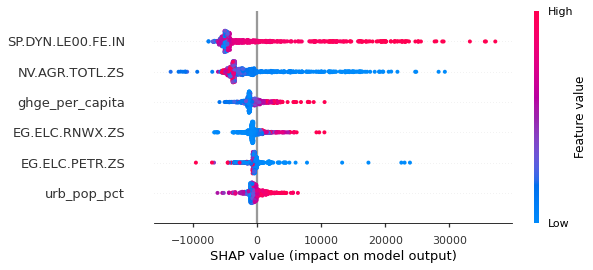

In [44]:
shap.summary_plot(shap_values, X_test)

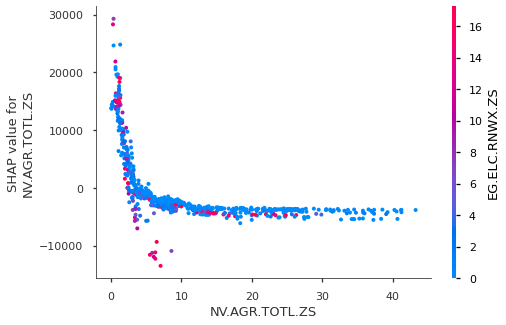

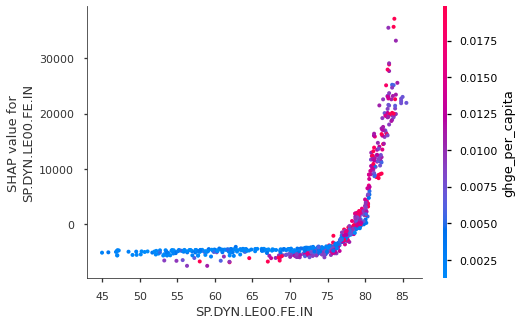

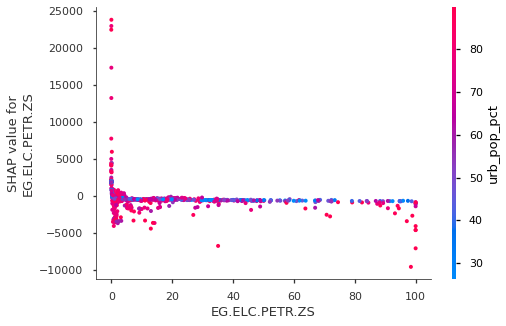

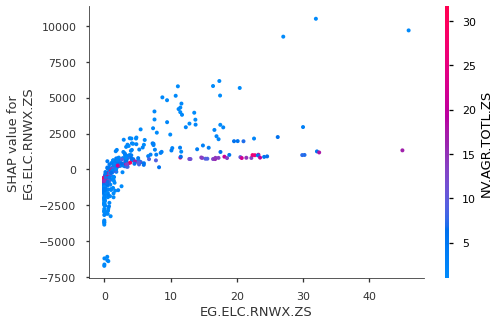

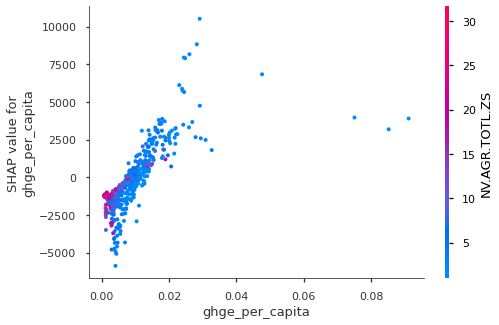

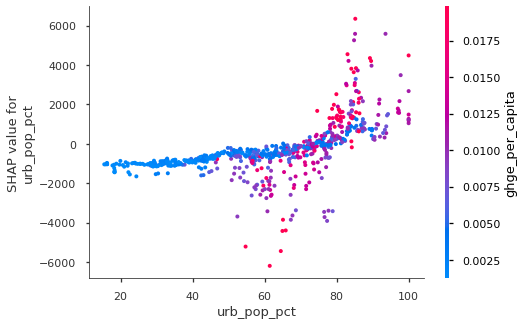

In [45]:
for s in X_test.columns:
    shap.dependence_plot(s, shap_values, X_test)